# Qradar Offense Notebook
Author: **@Ali_Alwashali**


![QradarLogo](qradarlogo.png)

### Dummy  Data

In [21]:
import requests 
import pandas as pd
import datetime
import re
import time
import matplotlib.pyplot as plt
from mpltools import layout
from mpltools import color
import urllib3


## Settings

In [27]:
## set your company color code, online color pickers resutl in rgba than need to be divied by 255 to make it between 0 and 1. 
color=[(0.57,0.81,0.31)]
#setting  
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

## Time Range
Sepcify Start day time and End day. 

In [28]:
#Qradar accepts time in millisecond 
startday = (datetime.datetime(2022,4,25,0,0) - datetime.datetime(1970,1,1)).total_seconds() * 1000 
endday = (datetime.datetime(2022,5,5,11,59) - datetime.datetime(1970,1,1)).total_seconds() * 1000

---
---

In [29]:
offenseURL = 'https://IPAddress/api/siem/offenses?filter=start_time%20%3E%20' + str(int(startday)) +"%20and%20start_time%20%3C%20" + str(int(endday))
crURL = 'https://IPAddress/api/siem/offense_closing_reasons'

headers=  {
           'Range': 'items=0-100000','Version': '16.0',
           'Accept': 'application/json',
           'SEC': 'Token'
          }

In [30]:
#offenses
ofR = requests.get(url = offenseURL,verify=False, headers=headers)
print("Offenses request status code: ", ofR.status_code)
data = ofR.json()

# Closing reason 
crR = requests.get(url = crURL,verify=False, headers=headers)
print("Closing Reason request status code: ", crR.status_code)
closeingReasons = crR.json()

Offenses request status code:  200
Closing Reason request status code:  200


In [ ]:
offenses = pd.DataFrame(data)

### Parsing epoch timestamps

In [33]:
offenses['offense_time'] = pd.to_datetime(offenses['start_time'],unit='ms')
offenses.set_index('offense_time')
print("Parsed Timestamp sample: ", offenses['offense_time'][1])

Parsed Timestamp sample:  2022-05-05 10:41:26.800000


-----

## Mapping Closing reason ID to text in a new column **closing_reason**. 

One reason should be for the escalated true incidents/cases, and another for the false positives which need to be further tuned if noisy.

In [34]:
for cr in closeingReasons: 
    offenses.loc[offenses['closing_reason_id'] == cr['id'], 'closing_reason'] = cr['text']
    print("ID: ", cr['id'], "   Name: ", cr['text'])

ID:  2    Name:  False-Positive, Tuned
ID:  1    Name:  Non-Issue
ID:  3    Name:  Policy Violation
ID:  256    Name:  Already-Reported
ID:  204    Name:  Delete
ID:  254    Name:  Escalated
ID:  255    Name:  False-Positive
ID:  154    Name:  Old Offenses
ID:  55    Name:  Resolved
ID:  104    Name:  Rule Need to be tuned
ID:  105    Name:  Rule Under Testing
ID:  257    Name:  To be monitored


## Total Cases;

In [35]:
offenses.shape[0]

493

## Date range 

In [36]:
print(offenses['offense_time'].max() - offenses['offense_time'].min())

10 days 11:48:07.814000


## Count of offenses by Closing Reason 

In [78]:
offenses['closing_reason'].value_counts()

False-Positive           324
To be monitored          141
Already-Reported          10
Escalated                  8
Rule Need to be tuned      7
False-Positive, Tuned      2
Name: closing_reason, dtype: int64

### offenses count by day

<AxesSubplot:xlabel='offense_time'>

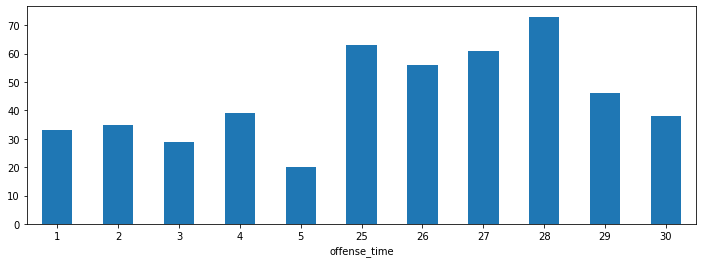

In [54]:
fig, axs = plt.subplots(figsize=(12, 4))
offenses.groupby(offenses['offense_time'].dt.day)['id'].count().plot(kind='bar', rot=0, ax=axs)

### offense count by hour

<AxesSubplot:xlabel='offense_time'>

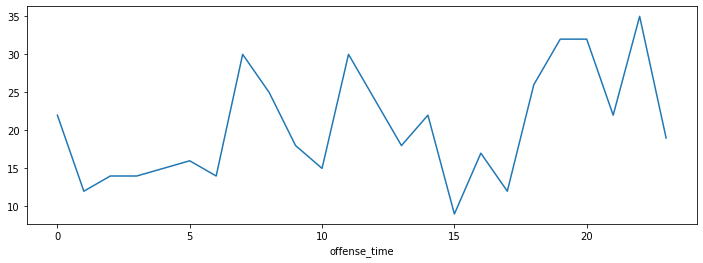

In [55]:
fig, axs = plt.subplots(figsize=(12, 4))
offenses.groupby(offenses['offense_time'].dt.hour)['id'].count().plot(kind='line', rot=0, ax=axs)

## Esclated cases by day 
You need to put the closing reason ID used in your Qradar. Refer the closing reason mapping step. 

Number of escalated offenses:  8


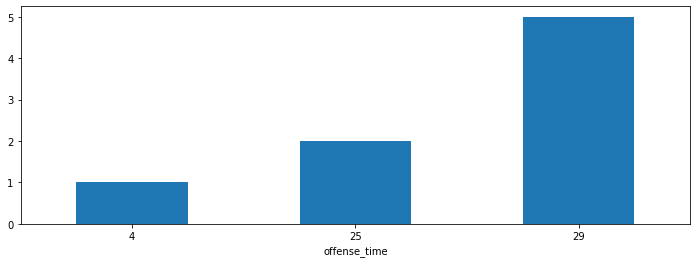

In [56]:
fig, axs = plt.subplots(figsize=(12, 4))
offenses[offenses['closing_reason'] == 'Escalated'].groupby(offenses['offense_time'].dt.day)['id'].count().plot(kind='bar', rot=0, ax=axs)
print("Number of escalated offenses: ", len(offenses[offenses['closing_reason'] == "Escalated"]))

## Group by status 


In [57]:
offenses['status'].groupby(by=offenses['status']).count()

status
CLOSED    492
OPEN        1
Name: status, dtype: int64

### Top Offesnes count
below shows the top x (can be changed in the code) rules with a count for the number of times triggered in the SIEM

In [114]:
offenses['description'].value_counts().rename_axis('offense').reset_index(name='counts').head(5)
## Names of the offense were changed

,offense,counts
0,SSh Related Offense,79
1,Scanner detected,65
2,Powershell abuse,48
3,BruteForce Detected against our amazing platform,41
4,High Number of Emails to Invalid Recipients from the Same Source\n containin...,38


## Group by offense source evidence

In [139]:
gp = offenses[['description','offense_source']].groupby(['description','offense_source']) 
gp.size().reset_index(name='counts').sort_values("counts", ascending=False).head(10)

,description,offense_source,counts
88,Powershell abuse,192.192.192.12,44
3,BruteForce Detected against our amazing platform,172.222.205.38,39
43,High Number of Emails to Invalid Recipients from the Same Source\n containin...,exch@Johny.com,38
39,Failure Audit: The domain controller failed to validate the credentials for ...,172.222.192..198,28
197,Someone Doesnt't like our FTP server,172.222.192..192.,20
190,Scanner detected,45.61.184.166,12
77,Multiple Login Failures with Root or Admin User\n containing User space auth...,192.157.84.18,11
163,Scanner detected,146.88.240.4,8
53,Johny :Local ICMP Scanner\n,172.222.192..82,8
195,Scanner detected,92.63.197.94,6


--- 

## Top noisy offenses sources 

There are cases were the noise is coming from only one or two items that can be easily tuned. The top 10 noisy rules are anlayzed for the most noisy source causing alerts to fire. 

In [153]:
# Top 10 triggered offense 
Names_ofTop10 = offenses["description"].value_counts().head(10).rename_axis('description').reset_index(name='counts')["description"]
top10 = pd.merge(offenses,Names_ofTop10,on='description')

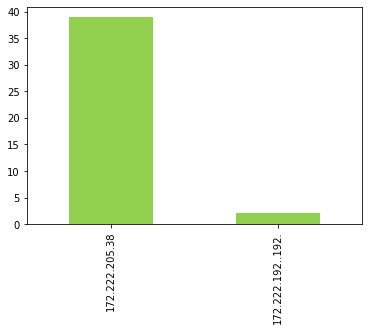

BruteForce Detected against our amazing platform




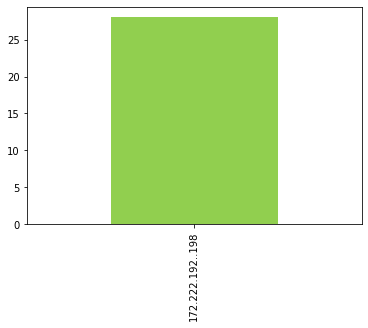

DC is angry on some account





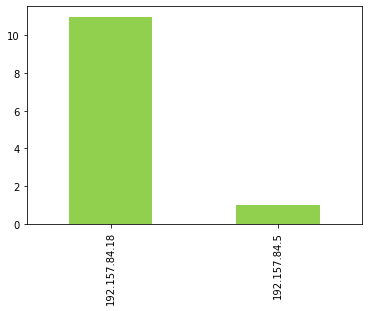

Multiple Login Failures with Superman or Batman User
 containing User space authentication failed





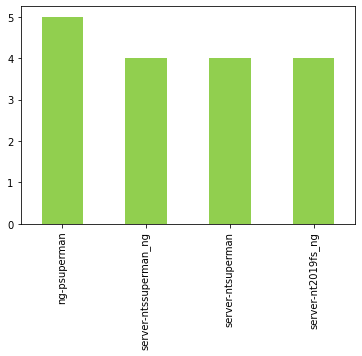

New Domain Batman Added




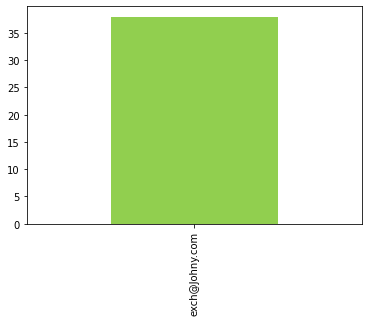

Pishing attempt
 containing MSGTRKMS::DSN





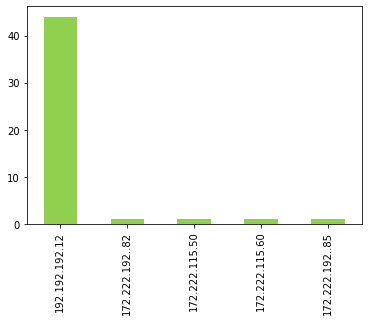

Powershell abuse




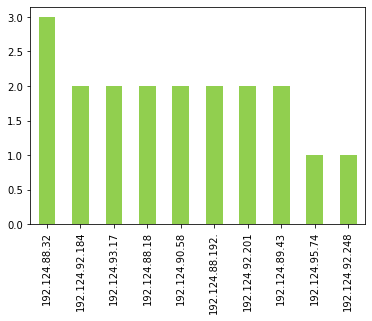

SSh Related Offense




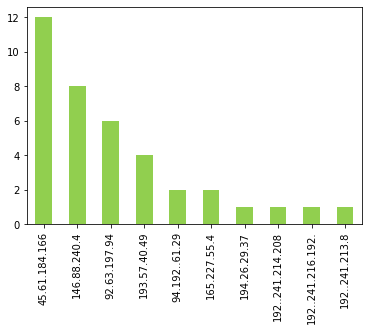

Scanner detected




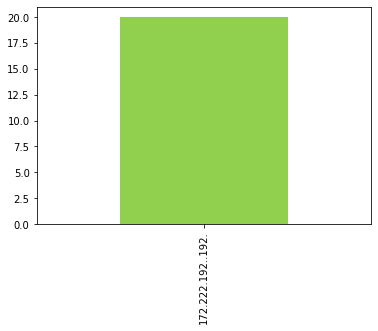

Someone Doesnt't like our FTP server




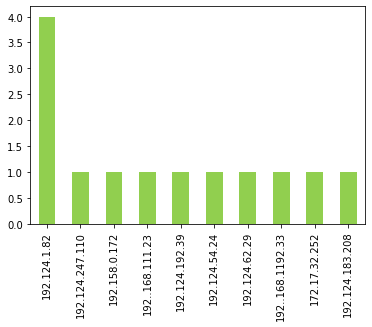

X-Force Match




In [154]:
top10_by_group = top10.groupby("description")
for name, group in top10_by_group:
    fig.suptitle(name)
    #print(group["offense_source"].value_counts().head(10))
    plt.figure()
    plot_data = group["offense_source"].value_counts().head(10)
    plot_data.plot(kind="bar",color=color, label=name)
    plt.show()
    print(name)
    print("\n")

## Top Destination offense items 
Follwoing graphs shows the most commuincated destinations by each rule. 

In [155]:
#local_destination_address_ids
offense_byDestinNetwork = pd.DataFrame(columns = ['offense','dest_id','dest_addr'])
dest_network_url = "https://IPAddress/api/siem/local_destination_addresses?filter=id%3D" 

for name, group in top10_by_group:
    for dest_addrs in group["local_destination_address_ids"].value_counts().head(10).rename_axis('dest_addr').reset_index(name='counts')["dest_addr"]:
        for addr_id in dest_addrs:
            if addr_id not in offense_byDestinNetwork['dest_id'].to_list():
                ofR = requests.get(url = dest_network_url+str(addr_id) ,verify=False, headers=headers)
                #print("Offenses request status code: ", ofR.status_code)
                data = ofR.json()
                MappedAddr = data[0]['local_destination_ip']
                t = pd.DataFrame([[group["description"], addr_id, MappedAddr]], columns = ['offense','dest_id','dest_addr'])
                offense_byDestinNetwork = pd.concat([offense_byDestinNetwork,t],ignore_index=True, axis = 0)
                time.sleep(0.05)
# convert local_destination_address_ids values from a list type to indvidual items by duplicating the rows for each value in a list  
top10 = top10.explode('local_destination_address_ids')

In [161]:
for dest_id in offense_byDestinNetwork['dest_id']:
    top10.loc[top10['local_destination_address_ids'] == dest_id, 'dest_addr'] = offense_byDestinNetwork[offense_byDestinNetwork['dest_id'] == dest_id].dest_addr.item()
    #print(top10[top10['local_destination_address_ids'] == dest_id]['local_destination_address_ids'])

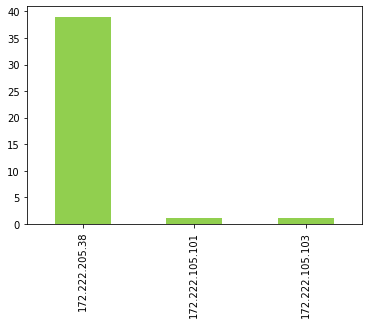

BruteForce Detected against our amazing platform




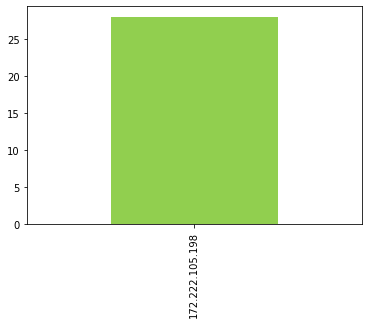

DC is angry on some account





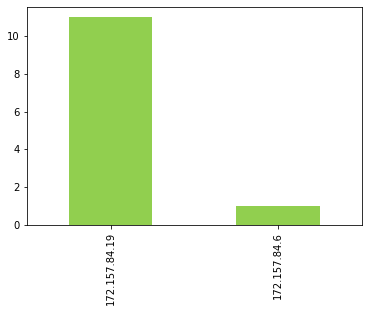

Multiple Login Failures with Superman or Batman User
 containing User space authentication failed





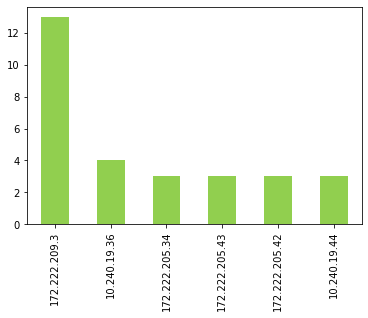

New Domain Batman Added




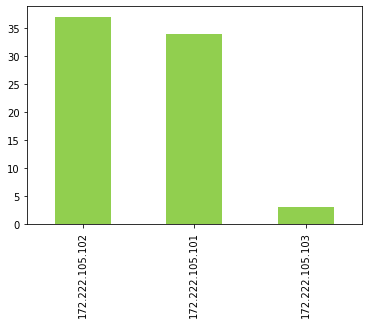

Pishing attempt
 containing MSGTRKMS::DSN





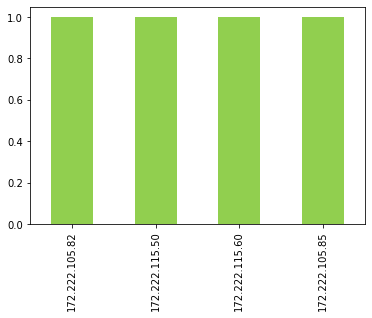

Powershell abuse




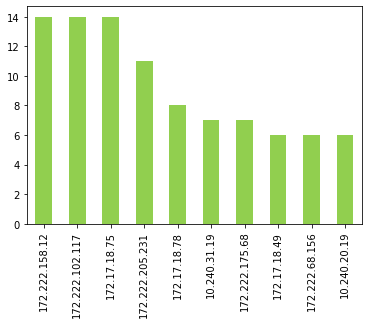

Scanner detected




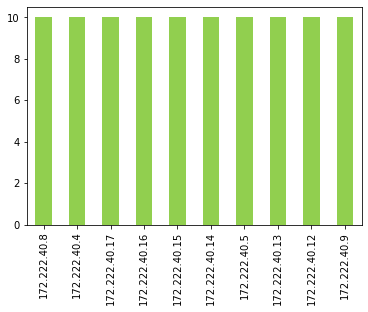

Someone Doesnt't like our FTP server




In [168]:
by_dest_addr = top10[top10['dest_addr'].notnull()].groupby(['description']) 
for name, group in by_dest_addr:
    fig.suptitle(name)
    #print(group["offense_source"].value_counts().head(10))
    plt.figure()
    plot_data = group["dest_addr"].value_counts().head(10)
    plot_data.plot(kind="bar",color=color, label=name)
    plt.show()
    print(name)
    print("\n")

## Top destination communicated in all offenses

In [169]:
top10['dest_addr'].value_counts().head(10)

172.222.205.38     39
172.222.105.102    37
172.222.105.101    35
172.222.105.198    28
172.222.158.12     14
172.17.18.75       14
172.222.102.117    14
172.222.209.3      13
172.222.205.231    11
172.157.84.19      11
Name: dest_addr, dtype: int64

## Top source networks with offenses
Qradar network and asset register must be correct in order to show the source of most of the incidents.

In [217]:
offenses[["source_network"]].value_counts().head(10).rename_axis('Source Network').reset_index(name='counts') 

,Source Network,counts
0,ChinaServers.USA_SF.USA_SF_F5,191
1,other,120
2,GuestZone,98
3,InZone.Unknown_subnet,14
4,InZone.VAS-Network,13
5,MarketingSubnet,11
6,VirtualizedEnv,6
7,LoadBalancedZoneDMZ,6
8,EarsZone.USA_DC.WifiU,6
9,WebZone_Protected,5


## Detections by Security security contorl - most frequent 
below shows the most log source causing the offenses. Security controls such as Firewalls, WAFs, EDRs are expected to have many telemetries and offenses to an accetpable level, but not servers and client machines. 

In [ ]:
logsources=[]
for ls in offenses["log_sources"]:
    for l in ls:
        if "Custom Rule Engine" not in l['name']:
            logsources.append(l['name'])
         
lsDF = pd.DataFrame(logsources)

In [248]:
lsDF.value_counts().head(10).rename_axis('Log Sources').reset_index(name='counts') 

,Log Sources,counts
0,FW@172.123.40.89,123
1,Z122UnixPPLANET,45
2,Z122Unix2,41
3,Z122UnixPDC01,40
4,syslog 172.123.172.198,40
5,Web_customMail@172.123.172.121,39
6,Exc@172.123.172.14,36
7,Z122UnixPSPDEV01,20
8,LinuxServer @ Laboratory-14,11
9,syslog 172.123.1.121,9


## Detections by Security security contorl - Least frequent
Least security controls contributing to the offenses. It's an indication if a security control is not sending or working as expcted

Least frequent will show machines and servers, if you are following a nameing convention, better to exclude servers to show the security contorls. 

In [ ]:
logsources=[]
# to exclude 
exclude = ['NameConvention0', 'WindowsServers', 'LinuxServers','NameConvention1']

def excluded(log_source):
    for e in exclude:
        if e.lower() in log_source.lower():
            return True
    return False
    

for ls in offenses["log_sources"]:
    for l in ls:
        if "Custom Rule Engine" not in l['name'] and not excluded(l['name']):
            logsources.append(l['name'])
         
lsDF = pd.DataFrame(logsources)



In [250]:
lsDF.value_counts().tail(20).rename_axis('Log Sources').reset_index(name='counts') 

,Log Sources,counts
0,WindowsAuthServer@172.123.205.172.,1
1,WindowsAuthServer@172.123.205.72,1
2,Z122UnixPACS01,1
3,Z122UnixPACS02,1
4,Z122UnixPAPPSPACE,1
5,Z122UnixPARCHMA01,1
6,Z122UnixPBAI03,1
7,Z122UnixPBMCENT02,1
8,Z122UnixPCA01,1
9,Z122UnixPLDR21,1


---

# Analysts perfromance 

## Distribution of offenses between analysts 

([<matplotlib.patches.Wedge at 0x1db085f4f40>],
 [Text(-1.1, 1.3471114790620887e-16, 'AnalystUser')])

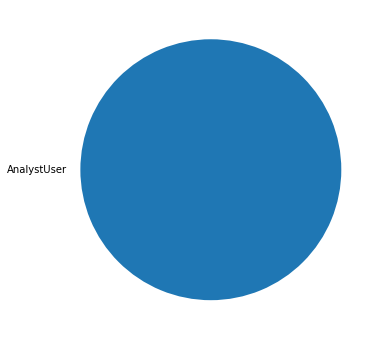

In [254]:
fig, axs = plt.subplots(figsize=(18, 6))
count =  offenses["assigned_to"].value_counts().head(20).rename_axis('Analyst').reset_index(name='counts')["counts"]
label =  offenses["assigned_to"].value_counts().head(20).rename_axis('Analyst').reset_index(name='counts')["Analyst"]
plt.pie(count,  labels = label)

## Analyst performance by day

<AxesSubplot:xlabel='offense_time'>

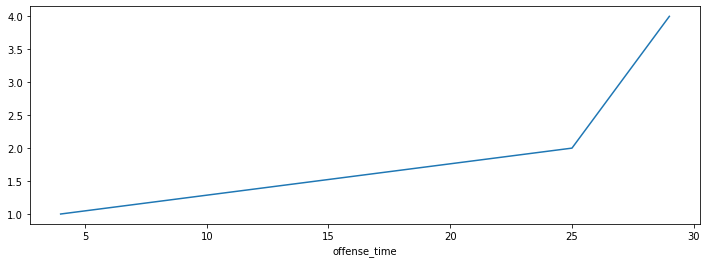

In [255]:
fig, axs = plt.subplots(figsize=(12, 4))
offenses[offenses['closing_reason'] == "Escalated"].groupby(offenses['offense_time'].dt.day)['assigned_to'].count().plot(kind='line',  rot=0, ax=axs)